https://github.com/spacetelescope/roman_notebooks/blob/main/content/notebooks/romanisim/romanisim.ipynb

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS

import os, sys
sys.path.append('/home/jiaxuanl/Research/SALAD/script/')
import kuaizi
from kuaizi.display import display_single
kuaizi.set_env(project='SBF', name='Rosesim', data_dir='/scratch/gpfs/JENNYG/jiaxuanl/Data')
# kuaizi.set_matplotlib(style='JL', usetex=True, fontsize=18, figsize=(7, 5), dpi=90)

'/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/Rosesim'

In [2]:
import asdf
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table, vstack, Column, hstack
from astropy import units as u
from astropy.visualization import simple_norm
import copy
import galsim
import roman_datamodels as rdm
from romanisim import gaia, bandpass, catalog, log, wcs, persistence, parameters, ris_make_utils as ris
from romanisim.image import inject_sources_into_l2
from romanisim.l3 import inject_sources_into_l3

## Load JAGUAR background galaxies

In [3]:
# cat_Q = Table.read("/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/JAGUAR/JADES_Q_mock_r1_v1.2.fits")
# cat_SF = Table.read("/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/JAGUAR/JADES_SF_mock_r1_v1.2.fits")
# cat_all = vstack([cat_Q, cat_SF])
# cat_all = cat_all[(cat_all['sersic_n'] < 6) & (cat_all['sersic_n'] > 0.35)]
# cat_all.write('/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/JAGUAR/JADES_all_mock_r1_v1.2.fits')

## Artpop and make catalogs

In [4]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = "30"

In [5]:
import artpop
sys.path.append('/home/jiaxuanl/Research/SBF/src/SBF')
import rosesim
from rosesim import RomanGalaxy, RomanSky, rng

In [26]:
obs_ra = 150.1049 #270.95
obs_dec = 2.2741 # -0.2

In [28]:
s = 5001
sky = RomanSky(obs_ra, obs_dec, xy_dim=np.array([s, s]), prefix='sky_jaguar')
radius = sky.xy_dim[0] * 0.11 / 3600
sky.obs_time = Time('2025-01-01T00:00:00')
sky.load_gaia_star(radius=radius)
sky.load_jaguar_bkg(radius=radius, seed=42)
sky.gen_catalog(include_bkg=True, include_gaia=True)

2025-08-13 01:42:23 INFO     Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Warning -- need to figure out the coefficients between JWST and Roman filters.
57 Gaia stars loaded.
21812 background galaxies loaded.


In [ ]:
exptime = 642 * 4 # HLWAS
sky.observe('F158', exptime=exptime)
sky.observe('F106', exptime=exptime)
sky.observe('F129', exptime=exptime)

Making mock Roman L3 image in F158 for sky_jaguar


2025-08-13 04:41:39 INFO     Starting simulation...
2025-08-13 04:41:39 WARNING  romanisim is under active development.  Its output has not been formally validated; only limited testing has been performed.  For this reason, use of romanisim for preparation of ROSES proposals is not advised.  Other packages like galsim's roman package or STIPS may better serve such purposes.
2025-08-13 04:41:39 INFO     Setting WCS reference to RA_ref=150.1049, Dec_ref=2.2741
2025-08-13 04:41:39 INFO     Simulating filter F158...
2025-08-13 04:41:39 INFO     Setting pixscale to match default.
2025-08-13 04:41:43 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2025-08-13 04:41:44 INFO     Using pupil mask 'F062' and detector 'WFI01'.
2025-08-13 04:41:44 INFO     Using pupil mask 'F062' and detector 'WFI02'.
2025-08-13 04:41:44 INFO     Using pupil mask 'F158' and detector 'WFI02'.
2025-08-13 04:41:44 INFO     No source spectrum supplied, therefore defaulting to 5700 K blackbody
2025-08-

Making mock Roman L3 image in F106 for sky_jaguar


2025-08-13 04:51:36 INFO     Starting simulation...
2025-08-13 04:51:36 WARNING  romanisim is under active development.  Its output has not been formally validated; only limited testing has been performed.  For this reason, use of romanisim for preparation of ROSES proposals is not advised.  Other packages like galsim's roman package or STIPS may better serve such purposes.
2025-08-13 04:51:36 INFO     Setting WCS reference to RA_ref=150.1049, Dec_ref=2.2741
2025-08-13 04:51:37 INFO     Simulating filter F106...
2025-08-13 04:51:37 INFO     Setting pixscale to match default.
2025-08-13 04:51:41 WARNING  wcs is None; unlikely to get orientation of PSF correct.
2025-08-13 04:51:42 INFO     Using pupil mask 'F062' and detector 'WFI01'.
2025-08-13 04:51:42 INFO     Using pupil mask 'F062' and detector 'WFI02'.
2025-08-13 04:51:42 INFO     Using pupil mask 'F106' and detector 'WFI02'.
2025-08-13 04:51:42 INFO     No source spectrum supplied, therefore defaulting to 5700 K blackbody
2025-08-

In [27]:
# rosesim.read_L3_asdf('./F158_642s.asdf')
# rosesim.asdf_to_fits(dm, 'F158_642s.fits', subtract_bkg=True)

# Visualize

In [30]:
from astropy.visualization import make_lupton_rgb

In [31]:
zp = -2.5 * np.log10(1 * ((0.11 * u.arcsec)**2).to(u.steradian).value * 1e6 / 3631)
print(zp)

25.265227862373404


In [34]:
filters = ['F106', 'F129', 'F158']
imgs = []
for filt in filters:
    # af = asdf.open(f'./{filt}_642s.asdf')
    af = asdf.open(f'./{filt}_10272s.asdf')
    dm = rdm.open(af)
    img = dm.data - np.median(dm.data)
    img *= 10**(0.4 * (27 - zp))
    imgs.append(img[:, :])

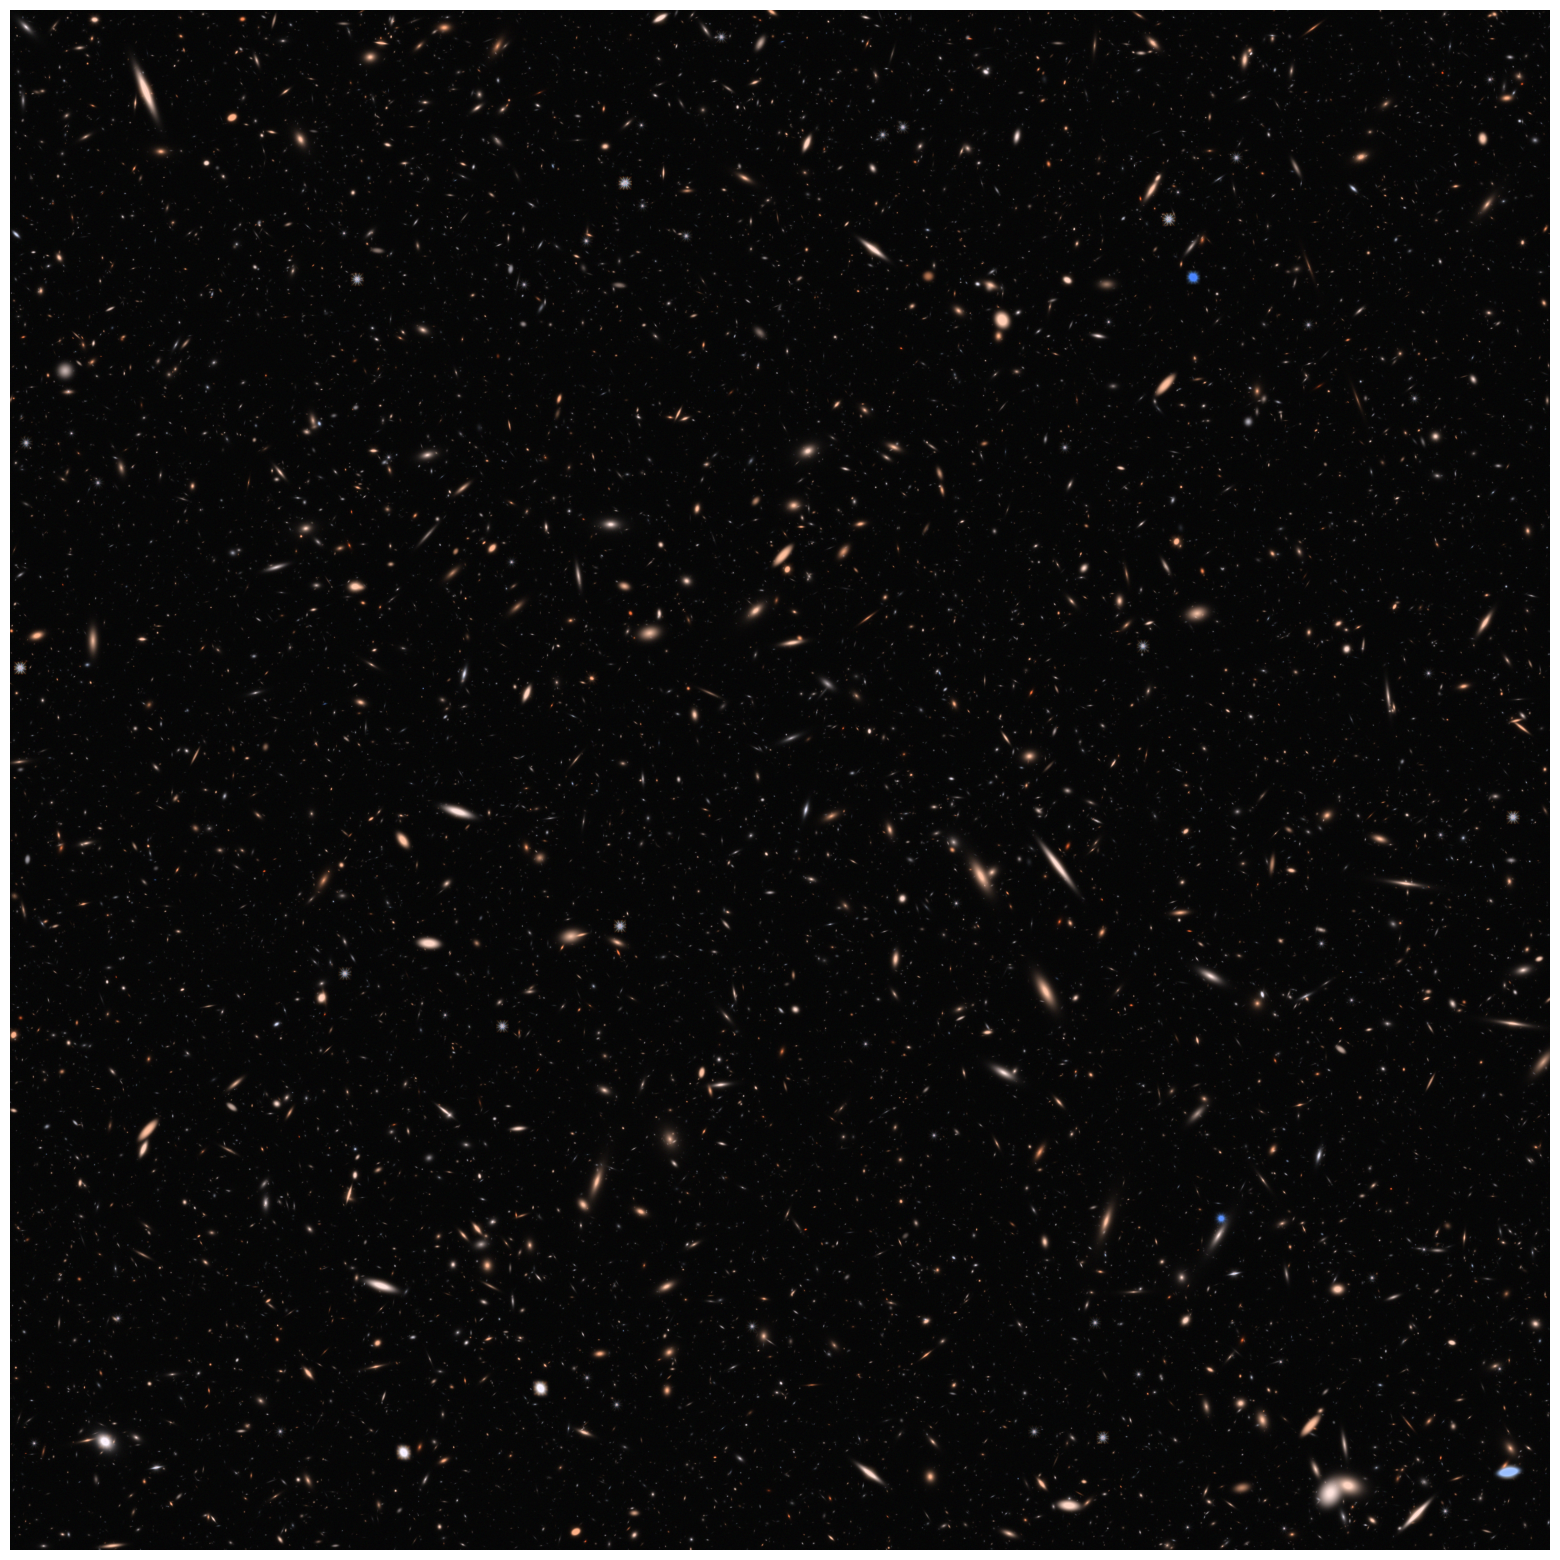

In [35]:
rgb = make_lupton_rgb(1.0 * imgs[2], 1.05 * imgs[1], 1.2 * imgs[0], minimum=-0.03, stretch=1, Q=4)
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(rgb)
plt.axis('off')

# plt.text(wid - 0.2 * wid, +5, filters[filt_idx[0]], 
         # fontsize=20, color='deepskyblue', va='center', ha='center')
# plt.text(wid, +5, filters[filt_idx[1]], 
         # fontsize=20, color='limegreen', va='center', ha='center')
# plt.text(wid + 0.2 * wid, +5, filters[filt_idx[2]], 
         # fontsize=20, color='orangered', va='center', ha='center')
# title = '$\mathrm{Age} = ' + f'{gal_kwargs["age"].to(u.Gyr).value:.1f}' + '\ \mathrm{Gyr}$, '
# title += '$\mathrm{[Fe/H]}=' + f'{gal_kwargs["feh"]:.1f}' + '$, '
# title += '$M_\star=10^{' + f'{np.log10(gal_kwargs["total_mass"]):.1f}' + '}\ M_\odot$, '
# title += '$D=' + str(int(gal_kwargs['distance'].to(u.Mpc).value)) + '$ Mpc'
# plt.title(title, fontsize=20)

plt.savefig('/tigress/jiaxuanl/public_html/figure/SBF/Rosesim/sky_10272s.png', bbox_inches='tight', dpi=200, transparent=True)

### Check https://tigress-web.princeton.edu/~jiaxuanl/figure/SBF/Rosesim/sky.png

---

In [21]:
dm = rosesim.read_L3_asdf("/scratch/gpfs/JENNYG/jiaxuanl/Data/SBF/Rosesim/sky_jaguar/F158_642s.asdf")

In [22]:
gwcs = dm.meta.wcs

In [25]:
gwcs.footprint()

array([[150.02843971,   2.19769392],
       [150.02843161,   2.35050203],
       [150.18136839,   2.35050203],
       [150.18136029,   2.19769392]])